### We will predict the daily number of posts published on Medium.

#### upload activity file provide to you

In [ ]:
from google.colab import files
data_to_load = files.upload()

Saving medium_posts.csv to medium_posts.csv


### Do the following:
1. load file in dataframe
2. drop na and drop duplicates
3. convert published column to datetime
4. sort values in published column by date
5. observe data using head() function
6. remove any data before august 15,2012

#### Aggregate count of posts per date. Remember date is published column in datetime format. you should obtain a df with one column with counts. name this column as posts.

In [ ]:
import pandas as pd
df = pd.read_csv('./medium_posts.csv', sep='\t')


In [ ]:
df.head()

,published,domain,url
0,2012-08-13 22:54:53.510Z,medium.com,https://medium.com/policy/medium-terms-of-serv...
1,2012-08-13 22:57:17.248Z,medium.com,https://medium.com/policy/medium-privacy-polic...
2,2016-11-04 23:40:43.364Z,medium.com,https://medium.com/@Medium/personalize-your-me...
3,2016-12-24 18:21:13.427Z,medium.com,https://medium.com/holiday-poems/xmas-morning-...
4,2015-09-22 21:37:48.207Z,blog.medium.com,https://blog.medium.com/taking-a-side-on-net-n...


In [ ]:
df['published'] = df['published'].apply(lambda x:x.replace('Z',''))
df['published'] = pd.to_datetime(df['published'])

In [ ]:
df = df[(df['published'] > '2012-08-15')].sort_index()

In [ ]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)


In [ ]:
### create aggr_df

In [ ]:
aggr_df = df.groupby('published')[['url']].count()
aggr_df.columns = ['posts']


In [ ]:
### As you can see data is in irregular time intervals. this we do the following operation to our aggr_df dataframe
aggr_df

,posts
published,
2012-08-15 00:25:03.373,1
2012-08-15 00:25:29.419,1
2012-08-15 00:34:59.502,1
2012-08-15 00:40:10.773,1
2012-08-15 00:58:25.898,1
...,...
2017-06-27 11:26:33.629,1
2017-06-27 12:01:15.006,1
2017-06-27 12:16:47.649,1


In [ ]:
# change irregular time intervals
daily_df = aggr_df.resample('D').apply(sum)
daily_df.head(n=3)

,posts
published,
2012-08-15,16
2012-08-16,11
2012-08-17,4


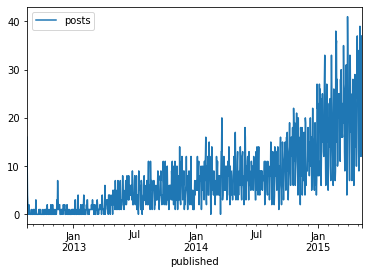

In [ ]:
daily_df.iloc[0:1000,:].plot()

In [ ]:
## use FB prophet 
## convert daily_df to include columns ds and y
df = daily_df.reset_index()
df.columns = ['ds', 'y']
# converting timezones (issue https://github.com/facebook/prophet/issues/831)
# df['ds'] = df['ds'].dt.tz_convert(None)
# df.tail(n=3)

In [ ]:
prediction_size = 30
train_df = df[:-prediction_size]
train_df.tail(n=3)

,ds,y
1745,2017-05-26,269
1746,2017-05-27,157
1747,2017-05-28,172


In [ ]:
### initialize prophet and fit train data
from fbprophet import Prophet
m = Prophet()
m.fit(train_df);

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
### make future dataframe for 30 days. name it future
future = m.make_future_dataframe(periods=prediction_size)
future.tail(n=3)

,ds
1775,2017-06-25
1776,2017-06-26
1777,2017-06-27


In [ ]:
#forecast future
forecast = m.predict(future)
forecast.tail(n=3)


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1775,2017-06-25,241.273014,204.776354,250.646611,241.204660,241.400917,-14.249142,-14.249142,-14.249142,-16.670714,-16.670714,-16.670714,2.421572,2.421572,2.421572,0.0,0.0,0.0,227.023872
1776,2017-06-26,241.705286,229.954609,273.432592,241.627257,241.861014,10.029112,10.029112,10.029112,7.586159,7.586159,7.586159,2.442953,2.442953,2.442953,0.0,0.0,0.0,251.734398
1777,2017-06-27,242.137559,231.493833,277.533148,242.049684,242.299373,11.799427,11.799427,11.799427,9.355012,9.355012,9.355012,2.444415,2.444415,2.444415,0.0,0.0,0.0,253.936986


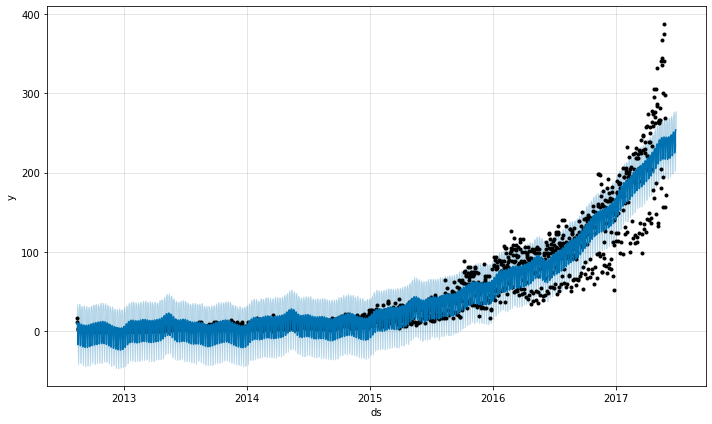

In [ ]:
#plot forecasted values
m.plot(forecast);